In [1]:
import pandas as pd
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Load Spotify Songs dataset
dataset = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "joebeachcapital/30000-spotify-songs",
    "spotify_songs.csv"
    )


Using Colab cache for faster access to the '30000-spotify-songs' dataset.


In [2]:
#####################################
##### PREPROCESSING OF THE DATA #####
#####################################
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# 1. STRATIFIED SAMPLING
# Extract 10000 rows maintaining the original proportion of genres.
# 'stratify' ensures that if 20% of the original data is Rock, 20% of the subset is Rock.
subset, _ = train_test_split(dataset, train_size=10000, stratify=dataset['playlist_genre'], random_state=42)

# Reset index to have clean indices from 0 to 9999
subset = subset.reset_index(drop=True)

# Display initial subset shape
print(f"Initial subset shape: {subset.shape}")

# 2. HANDLE MISSING VALUES
# Check for NaNs
nan_rows = subset.isna().any(axis=1).sum()
nan_perc = nan_rows / subset.shape[0] * 100
print(f"Rows with NaN values: {nan_rows} ({nan_perc:.2f}%)")

# Applying dropna on subset
subset.dropna(inplace=True)
print(f"Shape after dropping NaNs: {subset.shape}")

# 3. FEATURE SELECTION (DROPPING IRRELEVANT COLUMNS)
cols_to_drop = [
    'track_id',
    'track_name',
    'track_artist',
    'track_album_id',
    'track_album_name',
    'track_album_release_date',
    'playlist_name',
    'playlist_id',
    'playlist_subgenre',
    #'mode',
    #'key'
  ]

# Drop columns only if they exist in the dataframe
subset_clean = subset.drop(columns=cols_to_drop, errors='ignore')

# 4. SPLIT FEATURES (X) AND TARGET (y)
# We must separate the target variable BEFORE any further processing to avoid Data Leakage.
target_col = 'playlist_genre'

# y = The Labels (Target)
y = subset_clean[target_col]

# X = The Features (Numerical Audio Data)
# We drop the target column from X
X = subset_clean.drop(columns=[target_col])

# 5. FINAL VERIFICATION
print("\n--- Features (X) Head ---")
# This should contain only numerical columns like danceability, energy, tempo...
display(X.head())

print("\n--- Target (y) Head ---")
# This should contain the genres (pop, rock, etc.)
display(y.head())

# Check data types of X to ensure everything is numeric
print("\n--- X Data Types ---")
print(X.dtypes)

# Create a LabelEncoder to convert the labels ('playlist_genre') into numeric values
le = LabelEncoder()
encoded_y = le.fit_transform(y)

# Split the training set into training and validation set
X_train, X_val, y_train, y_val = train_test_split(X, encoded_y, test_size=0.25, random_state=24)


Initial subset shape: (10000, 23)
Rows with NaN values: 1 (0.01%)
Shape after dropping NaNs: (9999, 23)

--- Features (X) Head ---


,track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,81,0.584,0.540,1,-7.786,0,0.0576,0.0895,0.000000,0.261,0.1950,137.972,220883
1,71,0.811,0.695,5,-3.942,0,0.2460,0.3950,0.000000,0.109,0.5100,93.991,388800
2,45,0.460,0.793,0,-6.665,1,0.0434,0.5840,0.093000,0.151,0.5210,87.008,226173
3,33,0.326,0.396,4,-8.936,1,0.0324,0.8620,0.000090,0.109,0.0614,86.943,157500
4,56,0.549,0.963,3,-1.182,1,0.0594,0.0375,0.000007,0.429,0.4220,128.051,159375



--- Target (y) Head ---


,playlist_genre
0,pop
1,rap
2,rock
3,pop
4,edm



--- X Data Types ---
track_popularity      int64
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms           int64
dtype: object


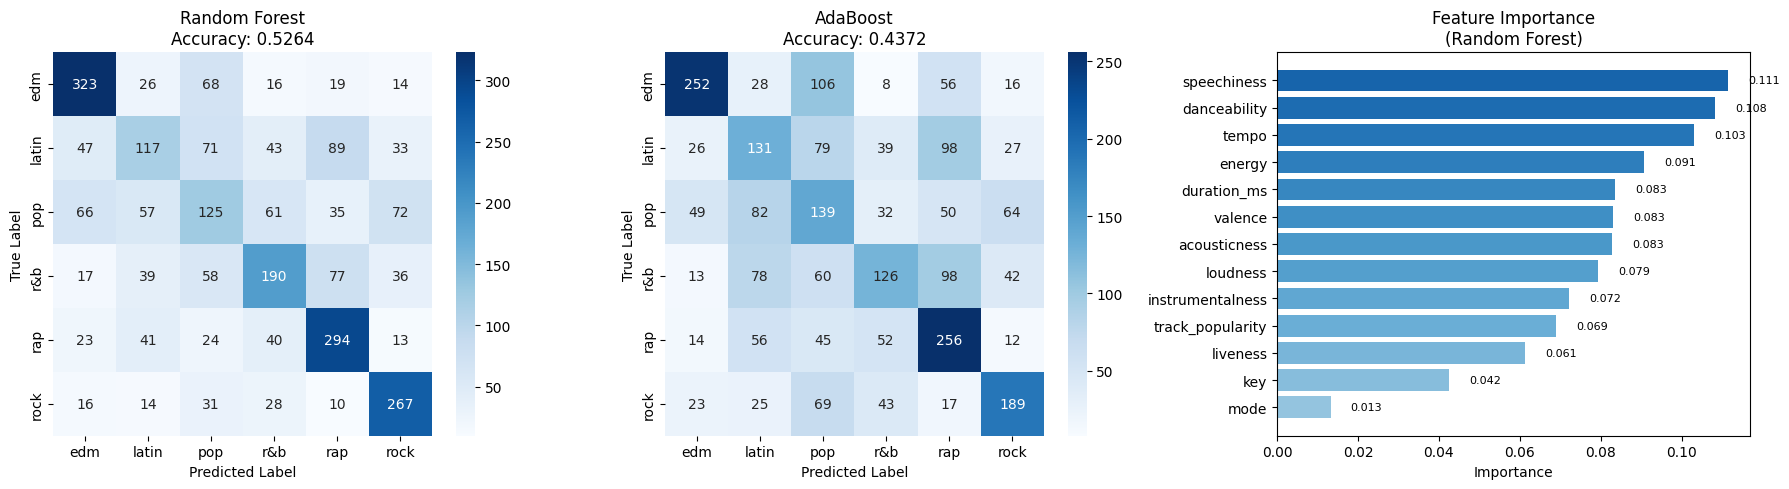

In [6]:
#############################
##### TREE-BASED MODELS #####
#############################
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Define the models in a list with their names for easier plotting
classifiers = [
    ("Random Forest", RandomForestClassifier(n_estimators=50, random_state=42)),
    ("AdaBoost", AdaBoostClassifier(n_estimators=50, random_state=42))
]

# 2. Create a figure with 3 subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Variable to store the best model for feature importance
best_model = None
best_acc = 0
best_name = ""

# 3. Iterate over the models to train and plot confusion matrices
for i, (name, model) in enumerate(classifiers):

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on validation set
    pred_val = model.predict(X_val)

    # Calculate Accuracy
    acc = accuracy_score(y_val, pred_val)

    # Keep track of the best model
    if acc > best_acc:
        best_acc = acc
        best_model = model
        best_name = name

    # Compute the Confusion Matrix
    cm = confusion_matrix(y_val, pred_val)

    # Plot the Heatmap on the specific subplot axis
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_,
                yticklabels=le.classes_,
                ax=axes[i])

    axes[i].set_title(f'{name}\nAccuracy: {acc:.4f}', fontsize=12)
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')

# 4. Plot Feature Importance from the best model (Random Forest)
# Get feature names (assuming X_train is a DataFrame, otherwise use your feature list)
if hasattr(X_train, 'columns'):
    feature_names = X_train.columns
else:
    # Replace with your actual feature names if X_train is a numpy array
    feature_names = ['danceability', 'energy', 'key', 'loudness', 'mode',
                     'speechiness', 'acousticness', 'instrumentalness',
                     'liveness', 'valence', 'tempo', 'duration_ms']

# Get feature importances
importances = best_model.feature_importances_

# Sort by importance
indices = np.argsort(importances)[::-1]
sorted_features = [feature_names[i] for i in indices]
sorted_importances = importances[indices]

# Create horizontal bar plot
colors = plt.cm.Blues(np.linspace(0.4, 0.8, len(sorted_features)))
axes[2].barh(range(len(sorted_features)), sorted_importances[::-1], color=colors)
axes[2].set_yticks(range(len(sorted_features)))
axes[2].set_yticklabels(sorted_features[::-1])
axes[2].set_xlabel('Importance')
axes[2].set_title(f'Feature Importance\n({best_name})', fontsize=12)

# Add value labels on bars
for j, v in enumerate(sorted_importances[::-1]):
    axes[2].text(v + 0.005, j, f'{v:.3f}', va='center', fontsize=8)

plt.tight_layout()
plt.show()

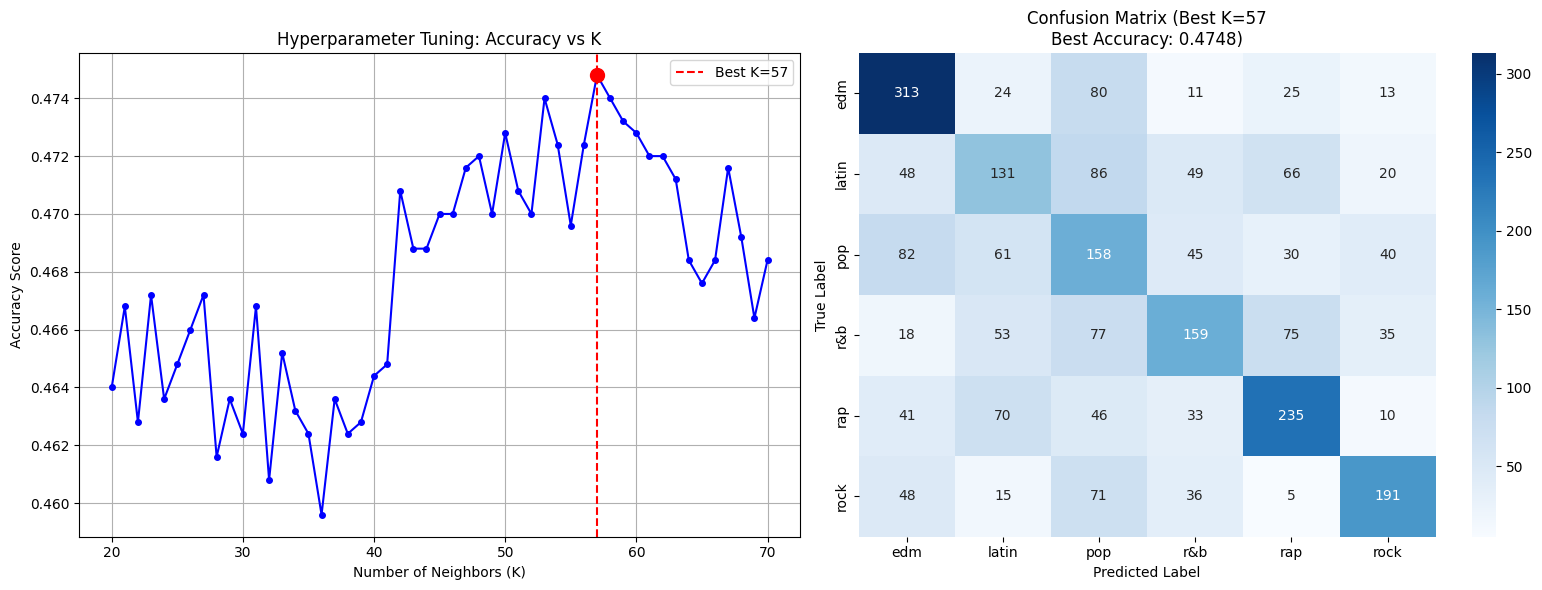

In [4]:
####################################
#### DISTANCE-BASED MODEL (KNN) ####
####################################
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix

# 1. SCALING (Crucial for KNN)
# We fit the scaler ONLY on training data to avoid data leakage
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_val_scaled = sc.transform(X_val) # Use transform() here, not fit_transform()

# 2. HYPERPARAMETER TUNING LOOP
k_values = []
accuracies = []
k_range = range(20, 71) # Range from 20 to 70

for k in k_range:
    # Initialize and train
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)

    # Predict and evaluate
    pred_val = knn.predict(X_val_scaled)
    acc = accuracy_score(y_val, pred_val)

    k_values.append(k)
    accuracies.append(acc)

# 3. FIND THE BEST K AUTOMATICALLY
best_acc = max(accuracies)
best_k = k_values[accuracies.index(best_acc)]

# 4. RE-COMPUTE PREDICTIONS FOR THE BEST K (For Confusion Matrix)
# We need to regenerate the predictions specifically for the winner model
best_model = KNeighborsClassifier(n_neighbors=best_k)
best_model.fit(X_train_scaled, y_train)
final_preds = best_model.predict(X_val_scaled)
cm = confusion_matrix(y_val, final_preds)

# 5. PLOTTING (2 Subplots side-by-side)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Plot 1: Accuracy Trend (Left) ---
axes[0].plot(k_values, accuracies, marker='o', linestyle='-', color='b', markersize=4)
axes[0].axvline(x=best_k, color='r', linestyle='--', label=f'Best K={best_k}') # Highlight winner
axes[0].scatter(best_k, best_acc, color='red', s=100, zorder=5) # Red dot on winner
axes[0].set_title('Hyperparameter Tuning: Accuracy vs K')
axes[0].set_xlabel('Number of Neighbors (K)')
axes[0].set_ylabel('Accuracy Score')
axes[0].legend()
axes[0].grid(True)

# --- Plot 2: Confusion Matrix (Right) ---
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, # Uses your LabelEncoder classes
            yticklabels=le.classes_,
            ax=axes[1]) # Draw on the second subplot

axes[1].set_title(f'Confusion Matrix (Best K={best_k}\nBest Accuracy: {best_acc:.4f})')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

In [5]:
################################
##### CLUSTERING (K-MEANS) #####
################################
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# 1. STANDARDIZATION (Crucial for PCA and K-Means)
# We use the dataset X (audio features only)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. PCA (DIMENSIONALITY REDUCTION to 3D)
# We reduce the 12+ audio features to just 3 Principal Components (X, Y, Z axes)
pca = PCA(n_components=3)
X_pca_3d = pca.fit_transform(X_scaled)

print(f"Original shape: {X_scaled.shape}")
print(f"PCA 3D shape:   {X_pca_3d.shape}")

# 3. K-MEANS CLUSTERING
# We look for 6 clusters (assuming there might be 6 distinct genres)
# Note: We fit K-Means on the full scaled data for better accuracy,
# then visualize the results in the 3D PCA space.
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# Silhouette score calculation
silhouette_avg = silhouette_score(X_scaled, cluster_labels)

# 4. PREPARE DATA FOR PLOTLY
df_viz = pd.DataFrame(X_pca_3d, columns=['PC1', 'PC2', 'PC3'])

# Add the Cluster ID found by K-Means
df_viz['Cluster_ID'] = cluster_labels.astype(str) # Convert to string for categorical coloring

# Add the True Genre (y) to compare via hover (if y is available)
# This allows you to mouse over a point and see: "Cluster: 2, Real Genre: Rock"
df_viz['Real_Genre'] = y.values

# 5. CREATE INTERACTIVE 3D PLOT
fig = px.scatter_3d(
    df_viz,
    x='PC1',
    y='PC2',
    z='PC3',
    color='Cluster_ID',       # Color points based on the Cluster found
    hover_data=['Real_Genre'], # Show the real genre when hovering
    title='3D Interactive Clustering: Spotify Genres',
    opacity=0.6,              # Make points slightly transparent to see depth
    size_max=5,               # Adjust dot size
    width=1000,
    height=800,
    template='plotly_dark'    # Cool dark theme
)

print(f"--- CLUSTERING RESULTS (K={k}) ---")
print(f"Silhouette Score: {silhouette_avg:.4f}")

# Show the plot
fig.show()

Original shape: (9999, 13)
PCA 3D shape:   (9999, 3)
--- CLUSTERING RESULTS (K=70) ---
Silhouette Score: 0.1016
